In [1]:
from collections import Counter
from flask import Flask, request, render_template, jsonify
import pickle
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import requests
import re
from bs4 import BeautifulSoup
import argparse
import time
from splinter import Browser
import time
from collections import defaultdict
import json
import re


In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
from src.cleaner import Cleaner 
import src.fantasy_scoring as fs

In [4]:
import requests
import boto3
from boto3.dynamodb.conditions import Key, Attr
import json
from decimal import Decimal

In [5]:
data = pd.read_csv("data/backtesting_data.csv")
data.head()

,gamescore_rank,assists,attempted_field_goals,attempted_free_throws,attempted_three_point_field_goals,blocks,date,defensive_rebounds,game_score,location,...,minutes,fg_pct,three_pct,two_pct,ft_pct,w,contest_date,player_y,pos_y,salary
0,11,2,6,4,3,0,10/17/17,3,11.9,Location.AWAY,...,19.533333,0.333333,0.333333,0.333333,1.000000,0,10/17/17,Terry Rozier,PG/SG,3800.0
1,19,10,9,0,4,1,10/17/17,7,8.4,Location.AWAY,...,33.066667,0.222222,0.000000,0.400000,0.000000,1,10/17/17,Chris Paul,PG,8000.0
2,16,5,7,7,2,1,10/17/17,7,9.6,Location.AWAY,...,32.116667,0.285714,0.000000,0.400000,0.714286,0,10/17/17,Al Horford,C,6000.0
3,7,3,14,0,7,2,10/17/17,6,14.9,Location.HOME,...,38.150000,0.428571,0.571429,0.285714,0.000000,0,10/17/17,Klay Thompson,SG,6200.0
4,9,0,23,2,9,0,10/17/17,5,12.1,Location.AWAY,...,39.600000,0.478261,0.222222,0.642857,0.500000,0,10/17/17,Jaylen Brown,SG/SF,3700.0


In [8]:
data.describe()['dk_score']

count    55380.000000
mean        21.202514
std         14.497690
min         -1.500000
25%         10.250000
50%         19.250000
75%         30.000000
max        103.500000
Name: dk_score, dtype: float64

In [13]:
data['dk_per_k']=data['dk_score']*1000/data['salary']

In [10]:
clnr = Cleaner()
data = clnr.transform(data)

In [11]:
data['date']=data['dt'].apply(lambda x: x.strftime("%Y-%m-%d"))

In [15]:
grp = data[data['minutes']>5].groupby(['name'])
summary=grp.aggregate({
    'dt':len,
    'minutes':['sum',np.mean],
    'td':['sum',np.mean],
    'dd':['sum',np.mean],
    'doubles':['sum',np.mean],
    'dk_per_min':[np.mean,np.median,'max',np.std],
    'dk_per_k':[np.mean,np.median,'max',np.std],
    'dk_score':[np.mean,np.median,'max'],
    'salary': [np.mean,np.median,'max',np.std],
    'pos_y':pd.Series.mode,
    'points':[np.mean,'max',np.std],
    'game_score':[np.mean,'max',np.std],
    'fg_pct':np.mean,
    'three_pct':np.mean,
    'two_pct':np.mean,
    'rebounds':np.mean,
    'offensive_rebounds':np.mean,
    'defensive_rebounds':np.mean,
    'assists':np.mean,
    'steals':np.mean,
    'blocks':np.mean,
    'turnovers':np.mean,
    'w':np.mean
}).sort_values(by=('dk_per_min','mean'),ascending=False)

In [16]:
data = data.merge(summary,how='left',right_index=True,left_on = 'name')

/Users/shane/anaconda3/lib/python3.7/site-packages/pandas/core/reshape/merge.py:522: UserWarning: merging between different levels can give an unintended result (1 levels on the left, 2 on the right)
  warnings.warn(msg, UserWarning)


In [30]:
pos =data['pos_y'].iloc[1]
pos
data = data.dropna(0,subset =['pos_y'])

In [31]:
positions = ['PG',"SG",'SF','PF','C']
for pos in positions:
    data[pos] = data['pos_y'].apply(lambda x:  (pos in set(x.split('/'))))
    
positions = ['G',"F",'C']
for pos in positions:
    data[pos] = data['pos_y'].apply(lambda x:  (pos in set(x.split('-'))))

/Users/shane/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [54]:
fld = 'height'
#pd.Series.quantile()
for pos in positions:
    print("{} {}, {}".format(pos, data[data['pos_y']==pos][fld].quantile(),data[data['pos_y']==pos][fld].quantile(0.75)))

PG 75.0, 75.0
SG 77.0, 78.0
SF 79.0, 80.0
PF 81.0, 82.0
C 85.0, 85.0


In [52]:
def get_n_scatter(data, f1, f2,n=1500,buckets = 10,ax = plt, ascending = True,alpha=0.7, s = 6):
    sub = data.iloc[::int(len(data)/n),:]
    lines= np.r_[0:len(sub):int(len(sub)/buckets)]
    out = np.zeros((buckets,2))
    temp_data = sub.sort_values(by = f1,ascending=ascending)
    #print(temp_data.shape)
    for ind,i in enumerate(lines[1:]):
        quantile = temp_data[f1].iloc[i]
        out[ind,0]=quantile
        sub = temp_data[(temp_data[f1]>=temp_data[f1].iloc[lines[ind]])&
                             (temp_data[f1]<=quantile)]
        #print(sub.shape)
        out[ind,1]=sub[f2].mean()
        ax.scatter(sub[f1],sub[f2],alpha = alpha, s = s )
    ax.set_xlabel(f1, size = 16)
    ax.set_ylabel(f2, size = 16)
    return pd.DataFrame(out,columns=[f1,f2])

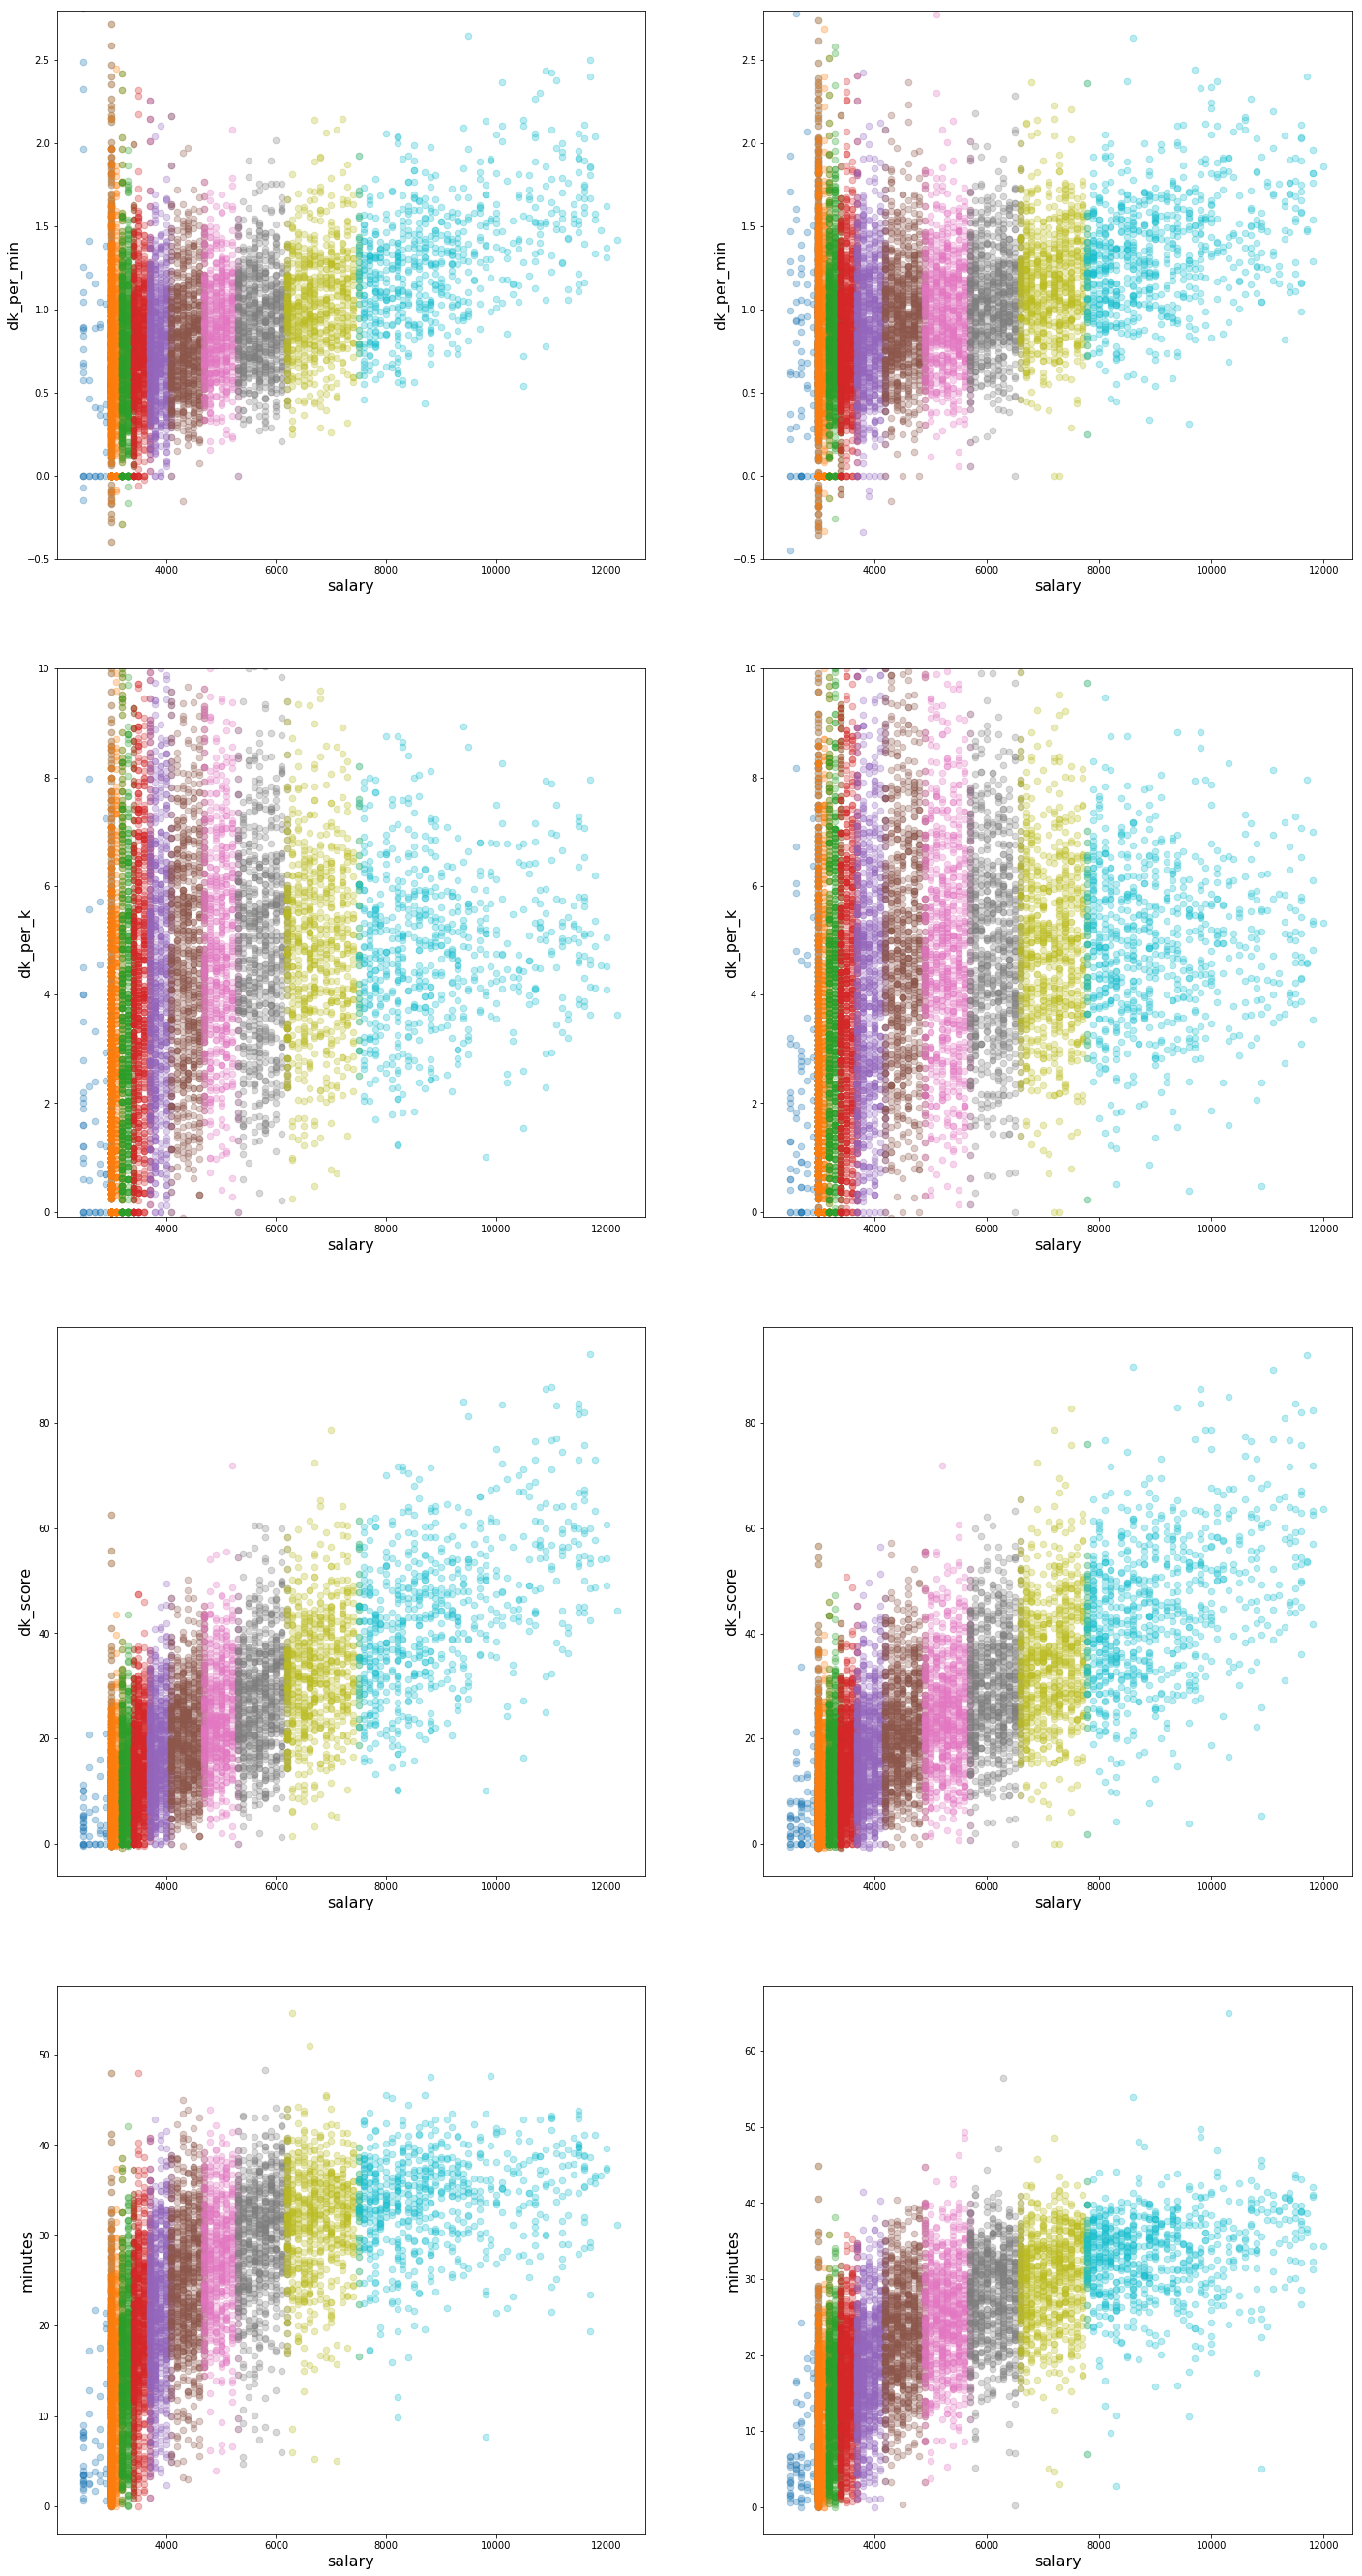

In [55]:
alpha = 0.3
n = 6000
f2 = 'dk_score'
combos = [('salary','dk_per_min'),
          ('salary','dk_per_k'),
          #('minutes','dk_per_min'),
          ('salary','dk_score'),
          ('salary','minutes')
          #('salary','dk_per_min'),
          #('dk_score','dk_per_min')
         ]
#fe = (both_stats[('dk_per_min','mean')] > 1)
fe = (data['C'] > 0)
fig, ax = plt.subplots(len(combos),2,figsize=(24,48))
buckets = [get_n_scatter(data,elem[0],elem[1],ax = ax[ind][0],alpha= alpha,n = n, s = 44) for ind,elem in enumerate(combos)]
buckets_fe = [get_n_scatter(data[fe],elem[0],elem[1],ax = ax[ind][1],alpha= alpha,n = n, s = 44) for ind,elem in enumerate(combos)]
#buckets = get_n_scatter(data,f1,f2,ax = ax[0], alpha , n )

[axs.set_ylim(-0.5,2.8) for axs in ax[0]]
[axs.set_ylim(-0.1,10) for axs in ax[1]]
plt.show()